In [1]:
import numpy as np
import networkx as nx
import tensorflow as tf
import scipy.sparse as sp
import matplotlib.pyplot as plt
import os, time

# set random seed
seed = 123
np.random.seed(seed)
tf.random.set_seed(seed)

from planetoid_dataset import load_planetoid, get_labels_mask
from utils.norm import norm_DF, norm_DADsm #, norm_DvH_WDe_HDv
from utils.convert import to_sparse_tensor

def get_nvidia_gpu_name(verbose=False) -> str:
    import subprocess
    sP = subprocess.Popen(['nvidia-smi', '-L'],
                          stdout=subprocess.PIPE,
                          stderr=subprocess.PIPE)
    out_str = sP.communicate()[0].decode()
    first_line = out_str.split('\n')[0]
    if verbose:
        print(first_line)
    if 'failed' in first_line.split():
        return 'No GPU'
    gpu_name = first_line[7:first_line.find(' (UUID:')]
    return gpu_name

gpu_name = get_nvidia_gpu_name(True)

GPU 0: NVIDIA GeForce GTX 1650 (UUID: GPU-41a5725f-7649-726c-df0a-11649896d2ba)


# 稀疏丟棄層

In [2]:
def sparse_dropout(x, rate, noise_shape):
    """
    Dropout for sparse tensors.
    """
    random_tensor = 1 - rate
    random_tensor += tf.random.uniform(noise_shape)
    dropout_mask = tf.cast(tf.floor(random_tensor), dtype=tf.bool)
    pre_out = tf.sparse.retain(x, dropout_mask)
    return pre_out * (1. / (1 - rate))


class SparseDropout(tf.keras.layers.Layer):
    def __init__(self, rate, num_features_nonzero, name=None, **kwargs):
        super(SparseDropout, self).__init__(name=name, **kwargs)
        self.rate = rate
        self.num_features_nonzero = num_features_nonzero

    def call(self, inputs, training=None):
        x = inputs
        if training is not False:
            x = sparse_dropout(x, self.rate, self.num_features_nonzero)
        return x

# 卷積層

In [3]:
# supports 為一個 稀疏張量的 list
# 如果是 第三代圖卷積，就會事先算好 D^(-0.5)@(A+In)@D^(-0.5) 後放進去
# 如果是 超圖卷積，就會事先算好 Dv^(-0.5)@H @ W@De^(-1) @ H@Dv^(-0.5) 後放進去

class GraphConvolution(tf.keras.layers.Layer):
    def __init__(self,
                 units,
                 supports,
                 is_sparse_inputs=False,
                 use_bias=True,
                 activation=None,
                 **kwargs):
        super(GraphConvolution, self).__init__(**kwargs)
        self.units = units
        self.supports = supports  # [sp_adj, ...]
        self.num_K = len(supports)

        self.is_sparse_inputs = is_sparse_inputs

        self.use_bias = use_bias
        self.activation = activation

    def build(self, input_shape):
        self.input_dim = input_shape[-1]
        self.output_dim = self.units
        self.kernel = self.add_weight(
            'kernel', [self.num_K, self.input_dim, self.output_dim],
            initializer='random_normal')
        if self.use_bias:
            self.bias = self.add_weight('bias', [self.output_dim],
                                        initializer='zeros')
        else:
            self.bias = None
        self.built = True

    def call(self, inputs):
        def dot(x, y, sparse=False):
            if sparse:
                res = tf.sparse.sparse_dense_matmul(x, y)
            else:
                res = tf.matmul(x, y)
            return res

        x = inputs
        # convolve
        supports = list()
        for i in range(self.num_K):
            pre_sup = dot(x, self.kernel[i], sparse=self.is_sparse_inputs)
            support = dot(self.supports[i], pre_sup, sparse=True)
            supports.append(support)
        output = tf.add_n(supports)
        # bias
        if self.use_bias:
            output += self.bias
        # activation
        if self.activation is not None:
            output = self.activation(output)
        return output

# GCN模型

In [4]:
class GCN(tf.keras.Model):
    def __init__(self, input_dim, output_dim, num_features_nonzero, supports,
                 hidden1_dim, dropout, **kwargs):
        super(GCN, self).__init__(**kwargs)
        self.input_dim = input_dim
        self.output_dim = output_dim

        self.sp_dropout_layer = SparseDropout(dropout, num_features_nonzero)
        self.gconv1 = GraphConvolution(units=hidden1_dim,
                                       supports=supports,
                                       is_sparse_inputs=True)
        self.relu = tf.keras.layers.ReLU()

        self.dropout_layer = tf.keras.layers.Dropout(dropout)
        self.gconv2 = GraphConvolution(units=output_dim, supports=supports)

    def call(self, inputs, training=None):
        x = inputs

        x = self.sp_dropout_layer(x, training)
        x = self.gconv1(x)
        x = self.relu(x)

        x = self.dropout_layer(x, training)
        x = self.gconv2(x)
        return x
    
class GCN_v2(tf.keras.Model):
    def __init__(self, input_dim, output_dim, num_features_nonzero, supports,
                 hidden1_dim, dropout, **kwargs):
        super(GCN_v2, self).__init__(**kwargs)
        self.input_dim = input_dim
        self.output_dim = output_dim

        ## self.sp_dropout_layer = SparseDropout(dropout, num_features_nonzero)
        self.gconv1 = GraphConvolution(units=hidden1_dim,
                                       supports=supports,
                                       is_sparse_inputs=True)
        self.relu = tf.keras.layers.ReLU()

        ## self.dropout_layer = tf.keras.layers.Dropout(dropout)
        self.gconv2 = GraphConvolution(units=output_dim, supports=supports)

    def call(self, inputs, training=None):
        x = inputs

        ## x = self.sp_dropout_layer(x, training)
        x = self.gconv1(x)
        x = self.relu(x)

        ## x = self.dropout_layer(x, training)
        x = self.gconv2(x)
        return x

# 計算具有遮罩 的 準確率 與 loss

In [5]:
def masked_softmax_cross_entropy(preds, labels, mask):
    """
    Softmax cross-entropy loss with masking.
    """
    loss = tf.nn.softmax_cross_entropy_with_logits(logits=preds, labels=labels)
    mask = tf.cast(mask, dtype=tf.float32)
    mask /= tf.reduce_mean(mask)
    loss *= mask
    return tf.reduce_mean(loss)


def masked_accuracy(preds, labels, mask):
    """
    Accuracy with masking.
    """
    correct_prediction = tf.equal(tf.argmax(preds, 1), tf.argmax(labels, 1))
    accuracy_all = tf.cast(correct_prediction, tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    mask /= tf.reduce_mean(mask)
    accuracy_all *= mask
    return tf.reduce_mean(accuracy_all)


def compute_loss_acc(output, label, mask, layer, weight_decay=5e-4):
    # 計算 loss
    loss = tf.zeros([])
    for var in layer.trainable_variables:
        loss += weight_decay * tf.nn.l2_loss(var)
    loss += masked_softmax_cross_entropy(output, label, mask)
    # 計算 acc
    acc = masked_accuracy(output, label, mask)
    return loss, acc

# def  Run Model 

In [6]:
def run_model(model,
              features,
              train_label,
              train_mask,
              val_label,
              val_mask,
              test_label,
              test_mask,
              epochs=200,
              lr=1e-2,
              weight_decay=5e-4):
    history_epoch = []
    history_loss = []
    history_accuracy = []
    history_val_loss = []
    history_val_accuracy = []
    latents = []
    #==========#==========#=====<>=====#==========#==========#
    train_time = 0.0
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    for epoch in range(epochs):
        #==========#==========#=====<train>=====#==========#==========#
        st = time.time()
        with tf.GradientTape() as tape:
            output = model(features)
            loss, acc = compute_loss_acc(output, train_label, train_mask,
                                         model.gconv1, weight_decay)
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        #==========#==========#=====<val>=====#==========#==========#
        output = model(features, training=False)
        val_loss, val_acc = compute_loss_acc(output, val_label, val_mask,
                                             model.gconv1, weight_decay)
        epoch_time = time.time() - st
        train_time += epoch_time
        #==========#==========#=====<latent space>=====#==========#==========#
        latent = model.gconv1(features).numpy()
        latents.append(latent)
        #==========#==========#=====<history>=====#==========#==========#
        loss, acc = float(loss), float(acc)
        val_loss, val_acc = float(val_loss), float(val_acc)
        history_epoch.append(epoch)
        history_loss.append(loss)
        history_accuracy.append(acc)
        history_val_loss.append(val_loss)
        history_val_accuracy.append(val_acc)
        if (epoch + 1) % 20 == 0 or epoch + 1 == epochs:
            print(f"{epoch+1:3}: loss={loss:.6f} acc={acc*100:10.6f}%", end="")
            print(f" | val_loss={val_loss:.6f} val_acc={val_acc*100:10.6f}%")
    #==========#==========#=====<Test>=====#==========#==========#
    st = time.time()
    output = model(features, training=False)
    test_loss, test_acc = compute_loss_acc(output, test_label, test_mask,
                                           model.gconv1, weight_decay)
    test_time = time.time() - st
    test_loss, test_acc = float(test_loss), float(test_acc)
    print(f"[Test]:\t test_loss={test_loss:.6f} test_acc={test_acc*100:10.6f}%")
    #==========#==========#=====<>=====#==========#==========#
    info = {}
    info["train_acc"] = acc
    info["train_loss"] = loss
    info["val_acc"] = val_acc
    info["val_loss"] = val_loss
    info["test_acc"] = test_acc
    info["test_loss"] = test_loss
    info["train_time"] = train_time
    info["test_time"] = test_time
    info["total_params"] = model.count_params()
    info['epochs'] = epochs
    info['optimizers'] = 'Adam'
    info['learning_rate'] = lr
    info['weight_decay'] = weight_decay
    info["history_epoch"] = history_epoch
    info["history_loss"] = history_loss
    info["history_accuracy"] = history_accuracy
    info["history_val_loss"] = history_val_loss
    info["history_val_accuracy"] = history_val_accuracy
    return info, latents

In [7]:
def save_json(info, folder='output', file_name='info', verbose=True):
    info['save_time'] = get_now_time_str()
    info['GPU'] = get_nvidia_gpu_name()
    
    # 建立 儲存輸出 的資料夾
    if not os.path.isdir(folder):
        os.mkdir(folder)
        print(f'mkdir: ./{folder}')

    # save info.json
    file_path = os.path.join(folder, f"{file_name}~{info['save_time']}.json")
    with open(file_path, 'w') as f:
        json.dump(info, f, indent=4)

    if verbose: print(f"Save {file_path}")


def get_now_time_str() -> str:
    import datetime
    return (datetime.datetime.utcnow() +
            datetime.timedelta(hours=8)).strftime("%Y%m%d_%H%M%S")

def get_nvidia_gpu_name(verbose=False) -> str:
    import subprocess
    sP = subprocess.Popen(['nvidia-smi', '-L'],
                          stdout=subprocess.PIPE,
                          stderr=subprocess.PIPE)
    out_str = sP.communicate()[0].decode()
    first_line = out_str.split('\n')[0]
    if verbose:
        print(first_line)
    if 'failed' in first_line.split():
        return 'No GPU'
    gpu_name = first_line[7:first_line.find(' (UUID:')]
    return gpu_name

# Main

In [8]:
def run_all(dataset_str='cora', model_str='GCN', split='random'):
    # dataset_str => 'cora' or 'citeseer' or 'pubmed'
    # split => 'random' or 'public'
    
    gd = load_planetoid(dataset_str, folder='download', verbose=False)
    gdx = get_labels_mask(dataset=gd,
                          split=split,
                          num_train_per_class=20,
                          num_val=500,
                          num_test=1000,
                          verbose=False)

    adj = gd['adj']

    if model_str in ['GCN', 'GCN_v2']:
        DAD = to_sparse_tensor(norm_DADsm(adj))
        supports = [DAD]  # 預先計算好給第三代圖卷積層用的
    else:
        assert True, '未定義模型'

    features = to_sparse_tensor(norm_DF(gd['features']))

    train_label = tf.convert_to_tensor(gdx['y_train'], dtype='float32')
    val_label = tf.convert_to_tensor(gdx['y_val'], dtype='float32')
    test_label = tf.convert_to_tensor(gdx['y_test'], dtype='float32')
    train_mask = tf.convert_to_tensor(gdx['train_mask'])
    val_mask = tf.convert_to_tensor(gdx['val_mask'])
    test_mask = tf.convert_to_tensor(gdx['test_mask'])
    
    if model_str == 'GCN':
        model = GCN(
            input_dim=gd['num_features'],
            output_dim=gd['num_classes'],
            supports=supports,  # 預先計算 [DAD]
            num_features_nonzero=(gd['num_features_nnz'], ),
            hidden1_dim=16,
            dropout=0.5)
    elif model_str == 'GCN_v2':
        model = GCN_v2(
            input_dim=gd['num_features'],
            output_dim=gd['num_classes'],
            supports=supports,  # 預先計算 [DAD]
            num_features_nonzero=(gd['num_features_nnz'], ),
            hidden1_dim=16,
            dropout=0.5)
        
    info, latents = run_model(model,
                              features,
                              train_label,
                              train_mask,
                              val_label,
                              val_mask,
                              test_label,
                              test_mask,
                              epochs=200,
                              lr=1e-2,
                              weight_decay=5e-4)

    info['dataset'] = dataset_str
    info['model'] = model_str
    
    save_json(info,
              folder='output',
              file_name=f"{info['model']}_{info['dataset']}_info",
              verbose=True)
    
    return info, latents

In [9]:
dataset_str='cora'
model_str='GCN'

info, latents = run_all(dataset_str=dataset_str, model_str=model_str, split='public')

 20: loss=1.887846 acc= 84.285712% | val_loss=1.924868 val_acc= 56.999999%
 40: loss=1.649740 acc= 90.714282% | val_loss=1.820998 val_acc= 70.999998%
 60: loss=1.266491 acc= 97.142851% | val_loss=1.632577 val_acc= 75.999993%
 80: loss=1.011434 acc= 96.428567% | val_loss=1.450095 val_acc= 79.199994%
100: loss=0.874049 acc= 97.142851% | val_loss=1.316571 val_acc= 79.799998%
120: loss=0.689799 acc= 97.142851% | val_loss=1.225935 val_acc= 80.000007%
140: loss=0.658209 acc= 98.571426% | val_loss=1.155660 val_acc= 79.399997%
160: loss=0.596580 acc= 97.857141% | val_loss=1.117878 val_acc= 78.200001%
180: loss=0.553052 acc= 97.857141% | val_loss=1.064228 val_acc= 79.600006%
200: loss=0.494523 acc= 97.857141% | val_loss=1.046604 val_acc= 78.399998%
[Test]:	 test_loss=0.997728 test_acc= 82.399994%
Save output\GCN_cora_info~20210730_164128.json


# 準確率曲線

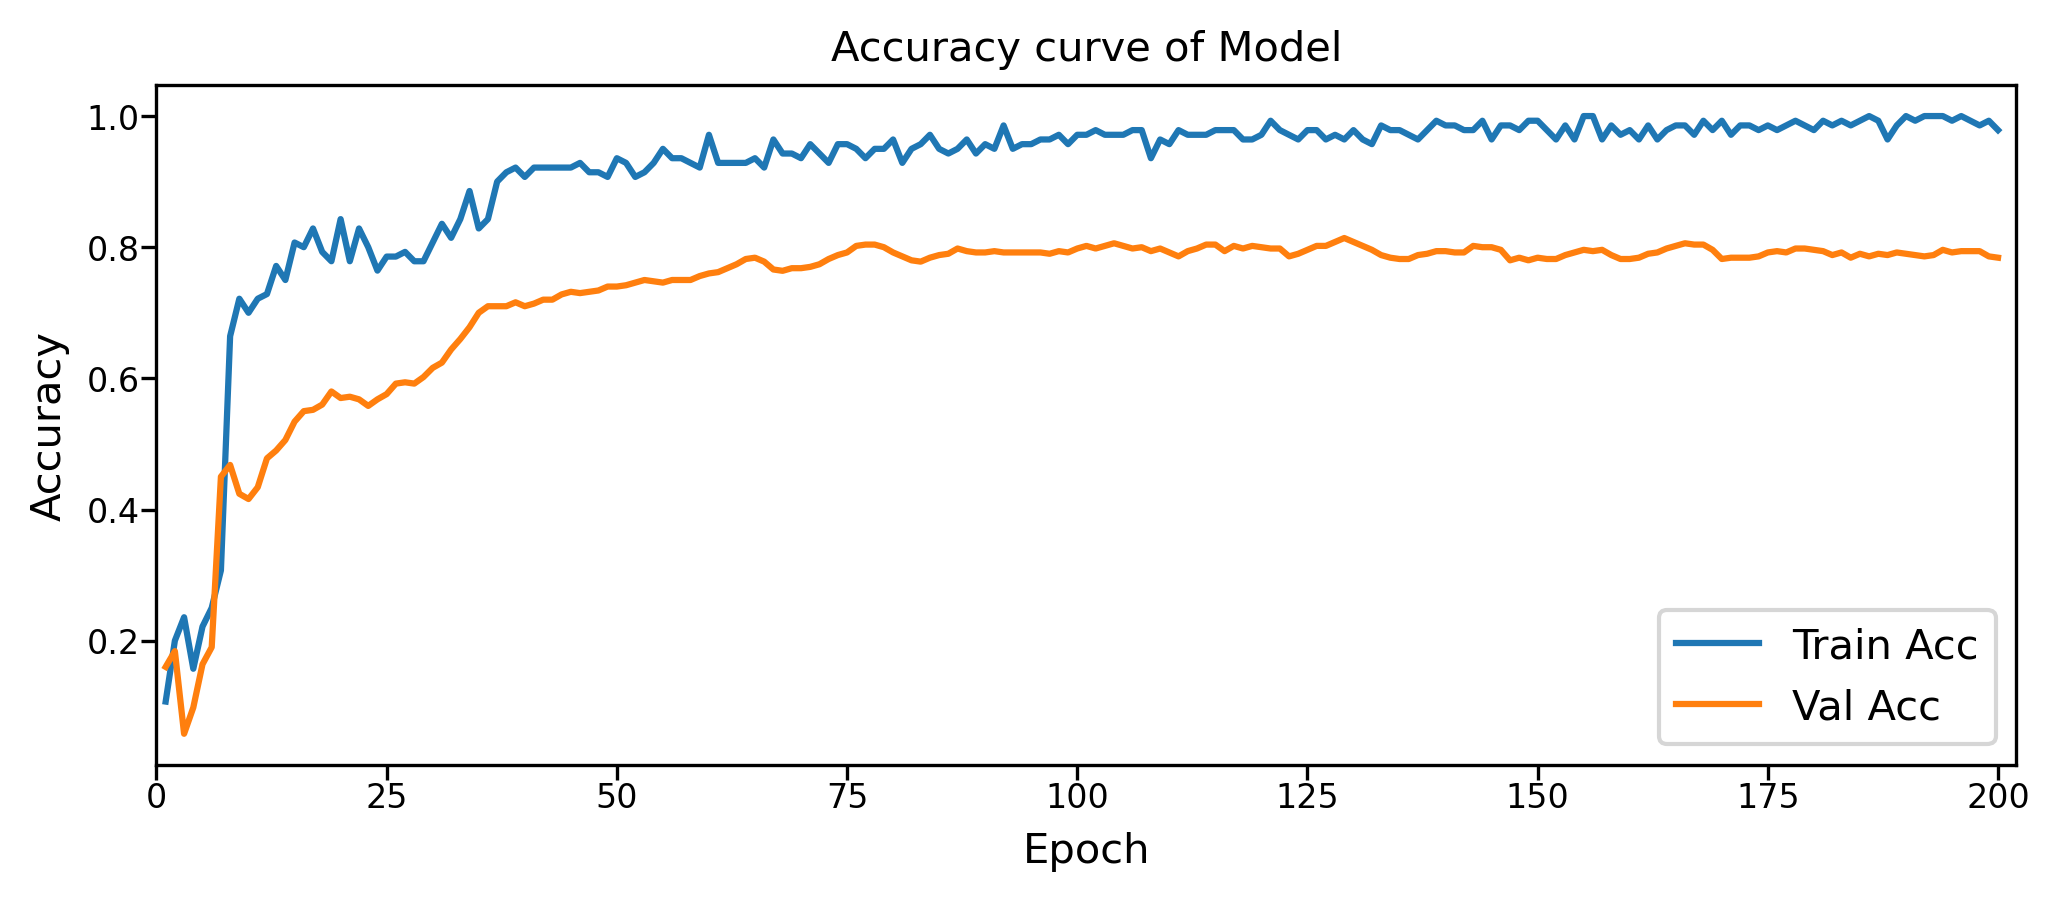

In [10]:
def show_acc_curve(h_acc,
                   h_val_acc,
                   h_acc_label='Train Acc',
                   h_val_acc_label='Val Acc',
                   title='Accuracy curve of Model'):
    fig, ax = plt.subplots(figsize=(8, 3), dpi=300)
    ax.set_xlim(left=0, right=len(h_acc) * 1.01)
    h_epoch = np.arange(len(h_acc)) + 1

    ax.plot(h_epoch, h_acc, color='C0', label=h_acc_label, linestyle='-')
    ax.plot(h_epoch, h_val_acc, color='C1', label=h_val_acc_label, linestyle='-')

    ax.set_title(title, fontsize=10)
    ax.set_ylabel('Accuracy', fontsize=10)
    ax.set_xlabel('Epoch', fontsize=10)
    ax.tick_params(pad=0.5, labelsize=8)
    ax.legend(loc='best')
    plt.close()
    #fig.savefig(fname=f'{title}.png', bbox_inches='tight', dpi=300, pad_inches=0.0)
    return fig


fig = show_acc_curve(h_acc=info['history_accuracy'], h_val_acc=info['history_val_accuracy'])

fig.savefig(f"acc_{model_str}_{dataset_str}.png", bbox_inches='tight', dpi=300, pad_inches=0.0)

fig

# loss曲線

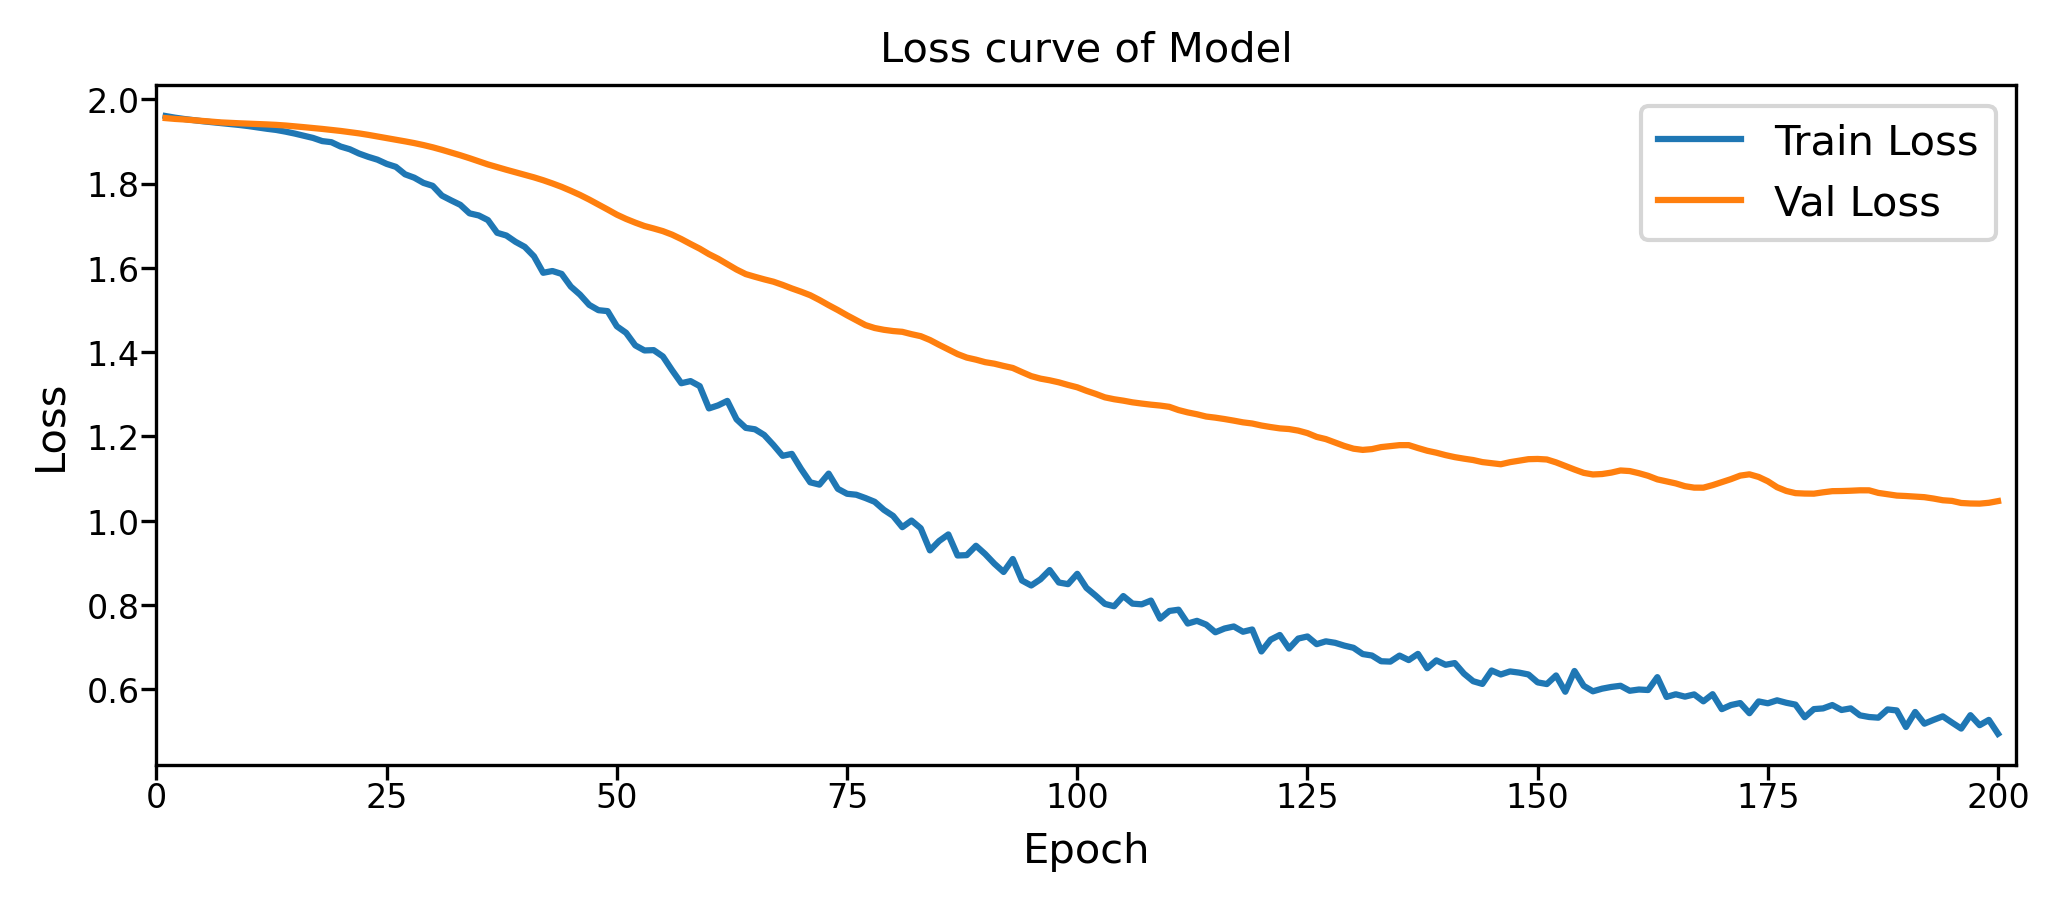

In [11]:
def show_loss_curve(h_loss,
                    h_val_loss,
                    h_loss_label='Train Loss',
                    h_val_loss_label='Val Loss',
                    title='Loss curve of Model'):
    fig, ax = plt.subplots(figsize=(8, 3), dpi=300)
    ax.set_xlim(left=0, right=len(h_loss) * 1.01)
    h_epoch = np.arange(len(h_loss)) + 1

    ax.plot(h_epoch, h_loss, color='C0', label=h_loss_label, linestyle='-')
    ax.plot(h_epoch, h_val_loss, color='C1', label=h_val_loss_label, linestyle='-')

    ax.set_title(title,
                 fontsize=10)
    ax.set_ylabel('Loss', fontsize=10)
    ax.set_xlabel('Epoch', fontsize=10)
    ax.tick_params(pad=0.5, labelsize=8)
    ax.legend(loc='best')
    plt.close()
    #fig.savefig(f'{title}.png', bbox_inches='tight', dpi=300, pad_inches=0.0)
    return fig
    
fig = show_loss_curve(h_loss=info['history_loss'], h_val_loss=info['history_val_loss'])

fig.savefig(f"loss_{model_str}_{dataset_str}.png", bbox_inches='tight', dpi=300, pad_inches=0.0)

fig

# 得到 t-SNE 將維後的座標 pos

In [12]:
from utils.tsne import t_SNE, get_num_str_colors

latent = latents[-1]  # 只看經最後一次epoch後的

# 得到 經 t_SNE 降維 後的 2維座標
pos = t_SNE(latent,
            init='pca',
            n_iter=1000,
            verbose=1,
            random_state=501,
            is_norm=True,  # x 和 y 皆做正規化 0~1
            is_pos=True)  # is_pos 轉成字典格式

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2708 samples in 0.006s...
[t-SNE] Computed neighbors for 2708 samples in 0.154s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2708
[t-SNE] Computed conditional probabilities for sample 2000 / 2708
[t-SNE] Computed conditional probabilities for sample 2708 / 2708
[t-SNE] Mean sigma: 0.086939
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.269585
[t-SNE] KL divergence after 1000 iterations: 1.077912


# 畫圖

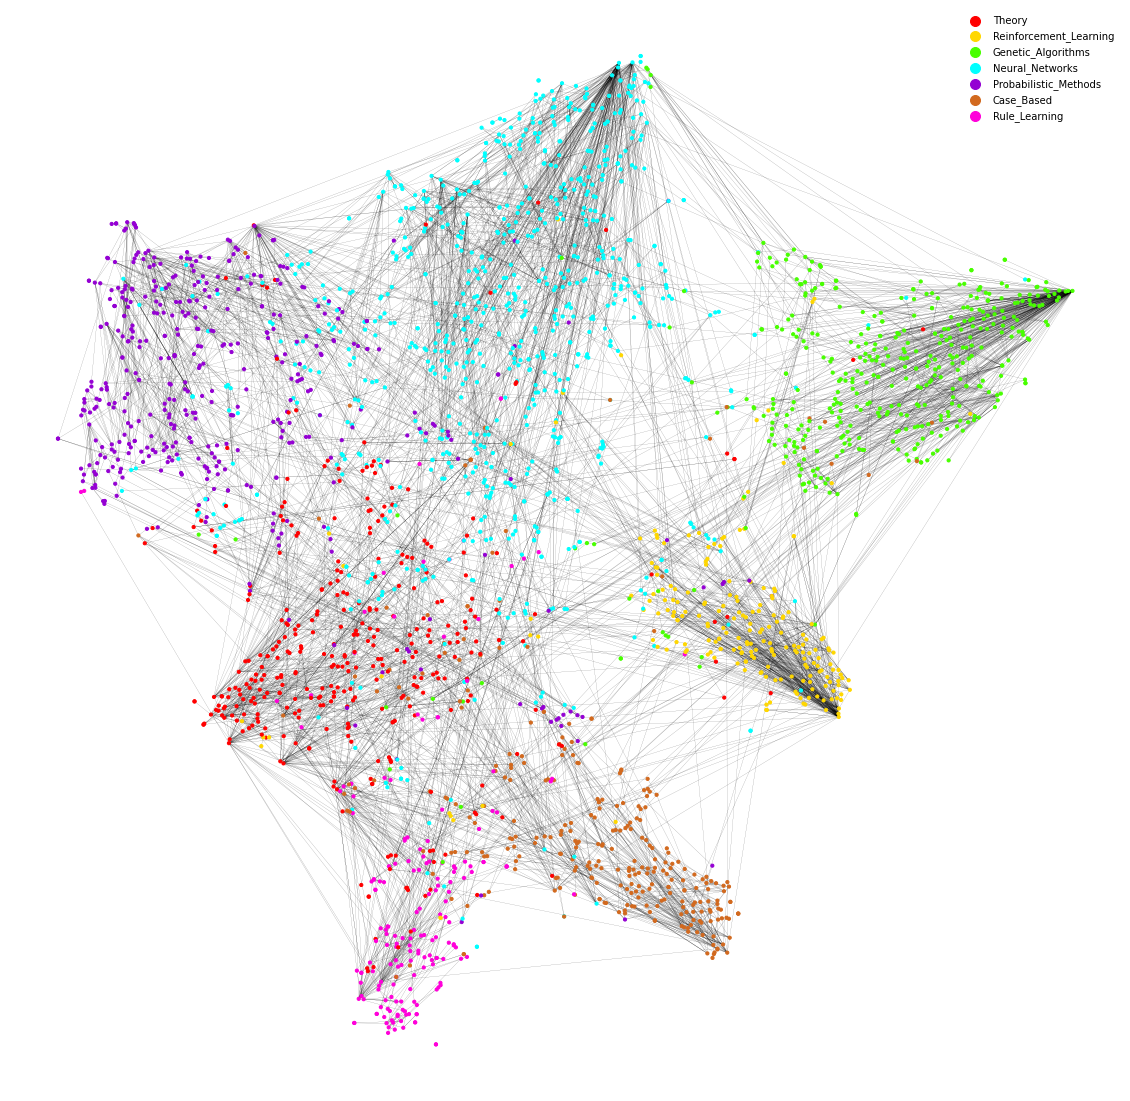

In [13]:
def show_graph(
        adj,
        pos,
        class_names,  # class_labels
        class_color,
        w=10,
        h=10,
        with_labels=False,
        alpha=1.0,
        padding=0.5,
        node_color='#8888FF',
        node_size=1000,
        node_shape='o',
        edge_color='#000000',
        edge_width=1.0,
        edge_style='solid',
        font_color='#000000',
        font_size=12):
    adj = sp.coo_matrix(adj)
    G = nx.from_scipy_sparse_matrix(adj)
    fig, ax = plt.subplots(figsize=(w, h))
    nx.draw(G,
            ax=ax,
            pos=pos,
            with_labels=with_labels,
            node_color=node_color,
            node_size=node_size,
            node_shape=node_shape,
            edge_color=edge_color,
            width=edge_width,
            style=edge_style,
            font_color=font_color,
            font_size=font_size)
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    ax.set_xlim(left=xmin - padding, right=xmax + padding)
    ax.set_ylim(bottom=ymin - padding, top=ymax + padding)
    if class_names is not None and class_color is not None:
        for name, color in zip(class_names, class_color):
            ax.scatter([], [], c=color, s=100, label=name)
        ax.legend(frameon=False)
    plt.close()
    return fig

gd = load_planetoid(dataset_str, folder='download', verbose=False)

adj = gd['adj']
true_labels = gd['true_labels'] # 每個節點的類別編號
class_labels = gd['class_labels'] # 類別標籤名稱

# 針對 citeseer 沒有標籤(true_labels[i] == -1)的節點加上 'Null'
if -1 in true_labels:
    class_names = class_labels + ['Null']
else:
    class_names = class_labels

# 各類別的色碼
class_color = get_num_str_colors(len(class_names), True)
# 轉換出 每一個節點對應顏色
color_labels = class_color[true_labels]  # node_color

fig = show_graph(
    adj,
    pos,
    class_names=class_names,
    class_color=class_color,
    w=20,
    h=20,
    node_size=10,
    edge_width=0.1,  #[0.1, 0.1, 0.02]
    with_labels=False,
    node_color=color_labels,
    padding=0.0)

fig.savefig(f"graph_{model_str}_{dataset_str}.png", bbox_inches='tight', dpi=300, pad_inches=0.0)

fig